# Generate users arrivals

Currently our paper work defines the arrivals of users as a function dependant on the price they pay $\rho$

$$\rho = (1+P)p \tag{1}$$

with $P\in [0,1]$ being the marginal benefit, and $p\in [m,M]$ the spot price.

[16] suggests to use a function like

$$ f(p_{norm}) = k(1-p_{norm}^a)^b,\quad p_{norm}\in[0,1] \tag{2}$$

$$ p_{norm} = \frac{p-m}{M-m} \tag{3}$$

to derive the arrivals of users asking for an instance, based on the normalized AWS spot price $p_{norm}$. Following its idea, we replace $x$ with the price the user pays $\rho$. And define:

$$ f_{old}(\rho) = \frac{k}{1 + \frac{\rho - m}{2M-m}} \left( 1 - \left(\frac{\rho}{2M}\right)^a \right)^b \tag{4} $$

$$ f(\rho) =
\begin{cases}
k \left( 1 - \left(\frac{\rho}{M}\right)^a \right)^b, & \rho\le M \\
0 & \rho>M\\
\end{cases} \tag{5}
$$
with $\rho=(1+P)p$

see the plot below to check how does it work.

0.0064 0.067


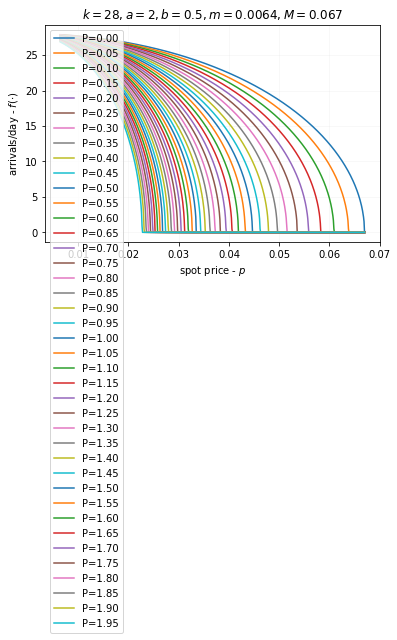

In [39]:
import matplotlib.pyplot as plt

def f(p, P, k, a=2, b=0.5, m=1, M=2):
    rho = (1+P)*p
    
    if rho > M:
        return 0
    return k  * (1 - (rho/M)**a)**b

# Plot an example for different margins P
a, b, k, m, M = 2, 0.5, 28, 0.006400, 0.067000
p = [i/10000 for i in range(int(10000*m), int(10000*M+1))]
print(p[0], p[-1])
for P in [i/100 for i in range(0, 200, 5)]:
    plt.plot(p, [f(pi, P=P, k=k, m=m, M=M) for pi in p], label=f'P={P:.2f}')
plt.legend(loc='upper left')
plt.xlabel('spot price - $p$')
plt.grid(alpha=0.1)
plt.ylabel('arrivals/day - $f(\cdot)$')
plt.title(f'$k={k}, a={a}, b={b}, m={m}, M={M}$');

Although the plot above shows how the arrival rate changes with the margin $P$ and spot price $p$, the function $f()$ just depends on the user price $\rho=\rho(p,P)$. See plot below:

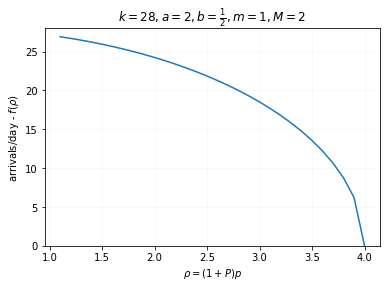

In [15]:
P = 0.5
def f_rho(rho, **kwargs):
    # lets just take P=0.5 in rho=(1+P)p
    p = rho / (1+P)
    return f(p=p, P=P, **kwargs)

def f_rho(rho, a=2, b=0.5):
    return k * (1 - (rho/(2*M))**a)**b

# Plot a function dependant on rho
rhosP05 = [pi*(1+P) for pi in p]
rhosP05 = [(i+1)/10 for i in range(m*10,2*M*10)]
plt.plot(rhosP05, [f_rho(rho=rho) for rho in rhosP05])
plt.ylim(0,28)
plt.xlabel('$\\rho=(1+P)p$')
plt.grid(alpha=0.1)
plt.ylabel('arrivals/day - $f(\\rho)$')
plt.title('$k=28, a=2, b=\\frac{1}{2}, m=1, M=2$');

## How to select $k$?

In equation (1) $k$ is the constant that scales the arrival rate. Therefore we must decide which value it takes (so as $a,b$).

We select $k$ so it follows [TID] arrival rates when the user price $\rho\in[m,2M]$ is in the middle, i.e, when $\frac{\rho-m}{2M-m}=0.5$.

For example, *t3a.small* instances have an arrival rate of 25 instances/day. Then, we generate *t3a.small* instances with an arrival rate $k$ such that $f(\rho=\frac{2M+m}{2})=25$.

Lets plot how it all looks with such a $k$:

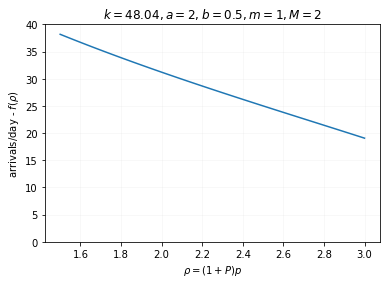

In [115]:
# Compute k
rho0 = (2*M+m)/2
k0 = (25 * (1 + (rho0-m)/(2*M-m))) / (1 - (rho0/(2*M))**a)**b

# Plot arrivals with computed k
plt.plot([(1+0.5)*pi for pi in p], [f(p=pi, P=0.5, k=k0, m=1, M=2) for pi in p])
plt.grid(alpha=0.1)
plt.ylim(0,40)
plt.xlabel('$\\rho=(1+P)p$')
plt.ylabel('arrivals/day - $f(\\rho)$');
plt.title(f'$k={k0:.2f}, a=2, b=0.5, m=1, M=2$');

## TID - $k$ selection

We will generate $k$ using [TID] reference values.
In particular, we relate their numbers to the
arrival of AWS-alike spot prices. Then, we set
$P=0$ so the user is charged by just the spot
price
$$ \rho = (1+P)p \underbrace{=}_{P=0} p $$

[TID] reports these numbers:

|-             | t3a.small | c5.2xlarge | c5d.4xlarge |
|--------------|-----------|------------|-------------|
|users/day     | 25        | 12.5       | 5           |


We derive $k$ s.t. $f(P=0,p=M/2)$ yields above
table values.

Ms= {'t3a.small': 0.0212, 'c5.2xlarge': 0.1572, 'c5d.4xlarge': 0.2449}
ms= {'t3a.small': 0.0064, 'c5.2xlarge': 0.1212, 'c5d.4xlarge': 0.2424}
M= 0.4898
k= {'t3a.small': 25.009928628963156, 'c5.2xlarge': 13.037595876897376, 'c5d.4xlarge': 5.763729739557513}
TID= {'t3a.small': 25, 'c5.2xlarge': 12.5, 'c5d.4xlarge': 5}


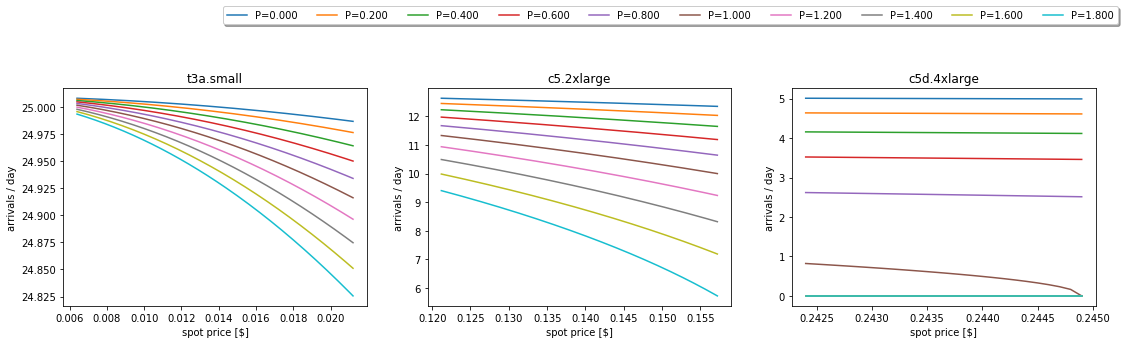

In [134]:
# load the train and test databases
import pandas as pd
train = pd.read_csv('ec2-prices-march-to-may.csv')
test = pd.read_csv('ec2-prices-june-july.csv')


# Obtain the highest M for each instance
#     "       lowest m  ""
Ms = {
    't3a.small': 0,
    'c5.2xlarge': 0,
    'c5d.4xlarge': 0,
}
ms = {
    't3a.small': 0,
    'c5.2xlarge': 0,
    'c5d.4xlarge': 0,
}
for inst in Ms.keys():
    # M
    M = train[(train['InstanceType'] == inst) &\
                   (train['ProductDescription'] == 'Linux/UNIX')]['SpotPrice'].max()
    Ms[inst] = max(M, test[(test['InstanceType'] == inst) &\
                  (test['ProductDescription'] == 'Linux/UNIX')]['SpotPrice'].max())
    # m
    m = train[(train['InstanceType'] == inst) &\
                   (train['ProductDescription'] == 'Linux/UNIX')]['SpotPrice'].min()
    ms[inst] = min(m, test[(test['InstanceType'] == inst) &\
                  (test['ProductDescription'] == 'Linux/UNIX')]['SpotPrice'].min())
print('Ms=',Ms)
print('ms=',ms)
M = max(Ms.values())
M = 2*M
print('M=',M)
#M = 1.090800 # c5d.18xlarge max price
# M = 0.080500 # c5d.xlarge max price
m = min(ms.values())

# Derive k for each instance
ks = {
    't3a.small': 0,
    'c5.2xlarge': 0,
    'c5d.4xlarge': 0,
}
tidfs = {
    't3a.small': 25,
    'c5.2xlarge': 12.5,
    'c5d.4xlarge': 5,
}
a, b = 2, 0.5
for inst in ks.keys():
    mid = (Ms[inst]+ms[inst])/2
    ks[inst] = tidfs[inst] / (1 - (mid/M)**a)**b
print('k=', ks)
print('TID=', tidfs)


# Derive plots of how arrivals vary depending on the P
fig, axs = plt.subplots(1,3)
i = -1
for inst in ks.keys():
    i += 1
    for P in [P/10 for P in range(0, 20, 2)]:
        p = [p/10000 for p in range(int(ms[inst]*10000), int(Ms[inst]*10000+1))]
        fs = [f(p=p_, P=P, k=ks[inst], a=a, b=b, m=m, M=M)\
              for p_ in p]
        axs[i].plot(p, fs, label=f'P={P:.3f}')
    axs[i].title.set_text(inst)
    axs[i].set_xlabel('spot price [$]')
    axs[i].set_ylabel('arrivals / day')
    #if i == 0: axs[i].legend(ncol=7)
fig.set_size_inches(18.5,4)
plt.legend(loc='upper center', bbox_to_anchor=(-0.4, 1.4),
          fancybox=True, shadow=True, ncol=11);
plt.show()

How does it look like against $\rho$:

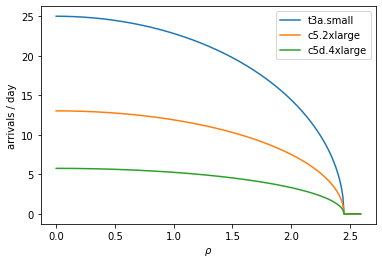

In [155]:
for inst in ks.keys():
    i += 1
    ps = [p_/100 for p_ in range(260)]
    fs = [f(p=p_/10, P=1, k=ks[inst], a=a, b=b, m=m, M=M)\
              for p_ in ps]
    plt.plot(ps, fs, label=inst)
plt.legend()
plt.xlabel('$\\rho$')
plt.ylabel('arrivals / day')
plt.show()

## What if we change $a,b$?

A higher $b$, results in a higher decay rate.

A higher $a$, results in lower decay.

Lets create multiple plots to check the behaviour:

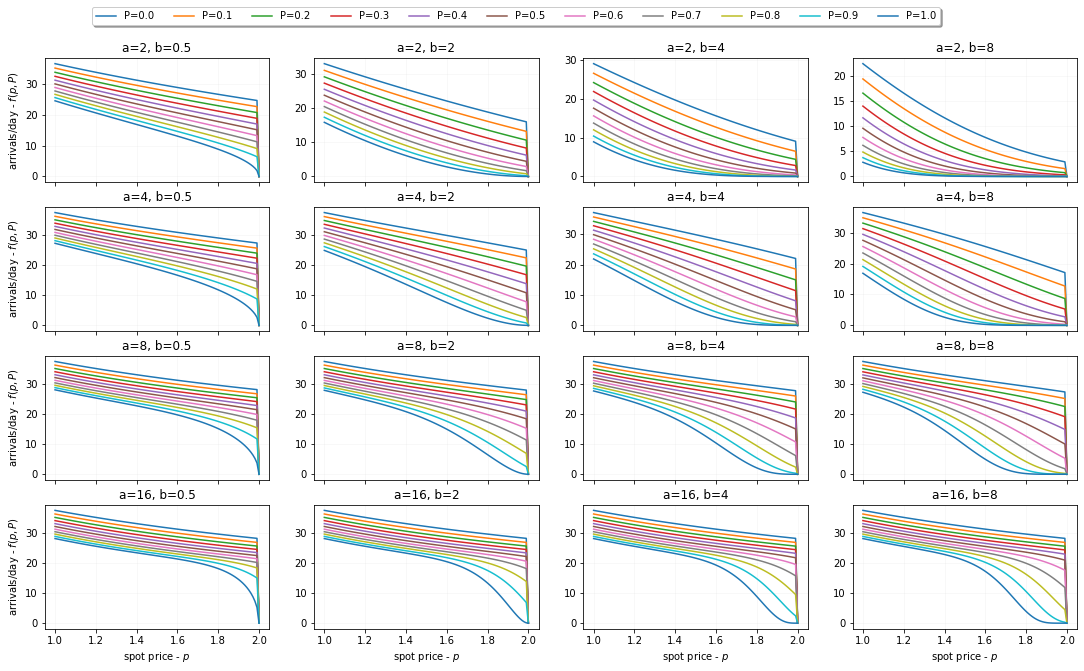

In [99]:
fig, axs = plt.subplots(4, 4, sharex=True)

# Change a and b
aidx=0
for a in [2, 4, 8, 16]:
    bidx = 0
    for b in [0.5, 2, 4, 8]:
        for P in [i/10 for i in range(11)]:
            axs[aidx, bidx].plot(p, [f(pi, P=P, k=k0, m=m, M=M, a=a, b=b) for pi in p], label=f'P={P:.1f}')
            axs[aidx, bidx].set_title(f'a={a}, b={b}')
            axs[aidx, bidx].grid(alpha=0.1)
            if aidx == 3:
                axs[aidx, bidx].set_xlabel('spot price - $p$')
            if bidx == 0:
                axs[aidx, bidx].set_ylabel('arrivals/day - $f(p,P)$')
        bidx += 1
    aidx += 1

# Save figure in tmp directory
fig.set_size_inches(18.5, 10.5)
plt.legend(loc='upper center', bbox_to_anchor=(-1.5, 5.05),
          fancybox=True, shadow=True, ncol=11)
#plt.savefig('/tmp/ab-changes.eps', metadata='eps')
plt.show()

## References
[16] G. George, R. Wolski, C. Krintz, and J. Brevik, “Analyzing aws spotinstance  pricing,”  in 2019 IEEE International Conference on Cloud Engineering (IC2E).    IEEE, 2019, pp. 222–228

[TID] Solano, Alberto, and Luis M. Contreras. "Information Exchange to Support Multi-Domain Slice Service Provision for 5G/NFV." 2020 IFIP Networking Conference (Networking). IEEE, 2020.